In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
!pip install torch torchvision

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split


df = pd.read_csv('/content/drive/MyDrive/Corrected_Labeled.csv', encoding='ISO-8859-1')
df.columns = df.columns.str.strip()  # Fix column names
df = df.dropna(subset=['Text', 'Label'])  # Drop missing labels or texts


print(df['Label'].value_counts())


train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Text'], df['Label'], test_size=0.15, random_state=42, stratify=df['Label']
)

tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# Tokenize
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)


Label
0.0    454
1.0    147
2.0     90
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)


Class weights: tensor([0.5069, 1.5653, 2.5746])


In [ ]:
class BioBERTClassifier(nn.Module):
    def __init__(self, num_labels=3):
        super(BioBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits


In [ ]:
from torch.utils.data import Dataset

class DiabetesDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = DiabetesDataset(train_encodings, train_labels)
val_dataset = DiabetesDataset(val_encodings, val_labels)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BioBERTClassifier().to(device)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=2e-5)


In [ ]:
from tqdm import tqdm
import copy

best_val_loss = float('inf')
patience = 2
patience_counter = 0
best_model_state = None

epochs = 10

for epoch in range(epochs):
    # Training phase
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} — Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = copy.deepcopy(model.state_dict())  # Save best model
        print("Validation loss improved — saving model.")
    else:
        patience_counter += 1
        print(f"No improvement. Early stopping counter: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

if best_model_state is not None:
    model.load_state_dict(best_model_state)


Epoch 1: 100%|██████████| 74/74 [00:08<00:00,  9.04it/s]


Epoch 1 — Train Loss: 0.9979, Val Loss: 0.8658
✅ Validation loss improved — saving model.


Epoch 2: 100%|██████████| 74/74 [00:07<00:00,  9.38it/s]


Epoch 2 — Train Loss: 0.6572, Val Loss: 0.8020
✅ Validation loss improved — saving model.


Epoch 3: 100%|██████████| 74/74 [00:07<00:00,  9.36it/s]


Epoch 3 — Train Loss: 0.3687, Val Loss: 0.9015
⚠️ No improvement. Early stopping counter: 1/2


Epoch 4: 100%|██████████| 74/74 [00:07<00:00,  9.38it/s]


Epoch 4 — Train Loss: 0.1638, Val Loss: 1.3027
⚠️ No improvement. Early stopping counter: 2/2
⏹️ Early stopping triggered.


In [ ]:
from sklearn.metrics import classification_report

target_names = ['True', 'False', 'Partially True']

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print(classification_report(all_labels, all_preds, target_names=target_names))


                precision    recall  f1-score   support

          True       0.82      0.88      0.85        68
         False       0.67      0.55      0.60        22
Partially True       0.38      0.36      0.37        14

      accuracy                           0.74       104
     macro avg       0.62      0.59      0.61       104
  weighted avg       0.73      0.74      0.73       104



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Diabetes_cleaned.csv")

print("Unique labels before mapping:", df['label'].unique())


Unique labels before mapping: [1 0]


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Diabetes_cleaned.csv")


print(df['label'].value_counts())
print(df['content'].head())

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df['label'],
    random_state=42
)


label
0    1661
1     608
Name: count, dtype: int64
0    natural news results of small study concluded ...
1    natural news there is plenty that pharmaceutic...
2    promoted for decades as safe sugar alternative...
3    natural news big sugar first began its campaig...
4    of readers think this story is fact. add your ...
Name: content, dtype: object


In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch

tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

class DiabetesDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(list(texts), padding=True, truncation=True, max_length=512)
        self.labels = list(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

# Datasets
train_dataset = DiabetesDataset(train_df['content'], train_df['label'])
val_dataset = DiabetesDataset(val_df['content'], val_df['label'])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [ ]:
from transformers import AutoModel
import torch.nn as nn

class BioBERTClassifier(nn.Module):
    def __init__(self):
        super(BioBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)  # Binary classification

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)


In [ ]:
import numpy as np
from tqdm import tqdm
import copy

best_val_loss = float('inf')
patience = 2
epochs_no_improve = 0
num_epochs = 10
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print("Early stopping triggered!")
            break


100%|██████████| 256/256 [00:41<00:00,  6.15it/s]


Epoch 1 | Train Loss: 0.3039 | Val Loss: 0.1231


100%|██████████| 256/256 [00:41<00:00,  6.17it/s]


Epoch 2 | Train Loss: 0.1029 | Val Loss: 0.0904


100%|██████████| 256/256 [00:41<00:00,  6.17it/s]


Epoch 3 | Train Loss: 0.0286 | Val Loss: 0.1006


100%|██████████| 256/256 [00:41<00:00,  6.17it/s]


Epoch 4 | Train Loss: 0.0041 | Val Loss: 0.1216
Early stopping triggered!


In [ ]:
from sklearn.metrics import classification_report

# Load best weights
model.load_state_dict(best_model_state)

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=['True', 'False']))


              precision    recall  f1-score   support

        True       1.00      0.95      0.97       166
       False       0.87      1.00      0.93        61

    accuracy                           0.96       227
   macro avg       0.94      0.97      0.95       227
weighted avg       0.97      0.96      0.96       227



In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/bio_model_best.pt")


#Domain Adaptation

In [ ]:

!pip install scikit-learn


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
print(target_df.columns)


Index(['Text ', 'Label'], dtype='object')


In [ ]:
# Load source data (labeled)
source_df = pd.read_csv("/content/drive/MyDrive/Diabetes_cleaned.csv")
source_df.dropna(subset=['content', 'label'], inplace=True)

# Load target data (unlabeled)
target_df = pd.read_csv('/content/drive/MyDrive/Corrected_Labeled.csv', encoding='ISO-8859-1')
target_df.dropna(subset=['Text '], inplace=True)


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

class TextDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=512)
        self.labels = labels.tolist() if labels is not None else None

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx])
        }
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create datasets
source_dataset = TextDataset(source_df['content'], source_df['label'])
target_dataset = TextDataset(target_df['Text '])


In [ ]:
from torch.autograd import Function

class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1.0):
        super().__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)


In [ ]:
class DANNModel(nn.Module):
    def __init__(self, num_labels=3):
        super().__init__()
        self.bert = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.dropout = nn.Dropout(0.3)

        # Task classifier (3-class)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        # Domain classifier
        self.grl = GradientReversal(lambda_=1.0)
        self.domain_classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.ReLU(),
            nn.Linear(256, 2)  # 2 domains: source=0, target=1
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        pooled_output = self.dropout(pooled_output)

        # Task prediction (only source)
        class_logits = self.classifier(pooled_output)

        # Domain prediction (source + target)
        reversed = self.grl(pooled_output)
        domain_logits = self.domain_classifier(reversed)

        return class_logits, domain_logits


In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer or AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.max_length = max_length

        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.texts)


In [ ]:

tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

source_dataset = TextDataset(
    texts=source_df['content'].tolist(),
    labels=source_df['label'].astype(int).tolist(),
    tokenizer=tokenizer
)

target_dataset = TextDataset(
    texts=target_df['Text '].tolist(),  # Note: Watch for trailing space in column name
    tokenizer=tokenizer
)


In [ ]:

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer or AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.max_length = max_length

        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.texts)

source_df = pd.read_csv("/content/drive/MyDrive/Diabetes_cleaned.csv").dropna()
target_df = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1').dropna()

tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

source_dataset = TextDataset(
    texts=source_df['content'].tolist(),
    labels=source_df['label'].astype(int).tolist(),
    tokenizer=tokenizer
)

target_dataset = TextDataset(
    texts=target_df['Text '].tolist(),  # Adjust to 'Text' if needed
    tokenizer=tokenizer
)

batch_size = 8
source_loader = DataLoader(source_dataset, batch_size=batch_size, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=batch_size, shuffle=True)

class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class DANNModel(nn.Module):
    def __init__(self, num_classes=2, hidden_size=768):
        super(DANNModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

        self.class_classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 2)  # source=0, target=1
        )

    def forward(self, input_ids, attention_mask, alpha=1.0):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # CLS token

        reverse_feature = ReverseLayerF.apply(pooled_output, alpha)

        class_logits = self.class_classifier(pooled_output)
        domain_logits = self.domain_classifier(reverse_feature)

        return class_logits, domain_logits

model = DANNModel(num_classes=2).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/bio_model_best.pt"), strict=False)

# === 7. Set Up Losses ===
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(source_df['label']),
    y=source_df['label']
)
task_criterion = nn.CrossEntropyLoss(
    weight=torch.tensor(class_weights, dtype=torch.float).to(device)
)
domain_criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

best_loss = float('inf')
patience = 2
epochs_no_improve = 0

for epoch in range(10):
    model.train()
    total_loss = 0

    for source_batch, target_batch in zip(source_loader, target_loader):
        optimizer.zero_grad()

        # Source
        src_input_ids = source_batch['input_ids'].to(device)
        src_attention_mask = source_batch['attention_mask'].to(device)
        src_labels = source_batch['labels'].to(device)

        # Target (unlabeled)
        tgt_input_ids = target_batch['input_ids'].to(device)
        tgt_attention_mask = target_batch['attention_mask'].to(device)

        # Alpha schedule
        p = epoch / 10
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Forward
        class_logits, domain_logits_src = model(src_input_ids, src_attention_mask, alpha)
        _, domain_logits_tgt = model(tgt_input_ids, tgt_attention_mask, alpha)

        # Losses
        task_loss = task_criterion(class_logits, src_labels)

        domain_labels_src = torch.zeros(len(src_labels), dtype=torch.long).to(device)
        domain_labels_tgt = torch.ones(len(tgt_input_ids), dtype=torch.long).to(device)
        domain_logits = torch.cat([domain_logits_src, domain_logits_tgt], dim=0)
        domain_labels = torch.cat([domain_labels_src, domain_labels_tgt], dim=0)
        domain_loss = domain_criterion(domain_logits, domain_labels)

        loss = task_loss + domain_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(source_loader)
    print(f"Epoch {epoch+1} | DANN Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/bio_dann_adapted.pt")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break


Epoch 1 | DANN Loss: 0.3063
Epoch 2 | DANN Loss: 0.7410
Epoch 3 | DANN Loss: 0.8227
Early stopping triggered.


In [ ]:
# === 1. Imports ===
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.texts)

source_df = pd.read_csv("/content/drive/MyDrive/Diabetes_cleaned.csv").dropna()
target_df = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1').dropna()

print("Source label distribution:")
print(source_df['label'].value_counts())


train_df, val_df = train_test_split(source_df, test_size=0.15, stratify=source_df['label'], random_state=42)

train_texts = train_df['content'].tolist()
train_labels = train_df['label'].astype(int).tolist()

val_texts = val_df['content'].tolist()
val_labels = val_df['label'].astype(int).tolist()

target_texts = target_df['Text '].tolist()


train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)
target_dataset = TextDataset(target_texts, None, tokenizer)


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class weights:", class_weights)
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=8)
target_loader = DataLoader(target_dataset, batch_size=8, shuffle=True)


class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class DANNModel(nn.Module):
    def __init__(self, num_classes=2, hidden_size=768):
        super(DANNModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.class_classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 2)
        )

    def forward(self, input_ids, attention_mask, alpha=1.0):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        reverse_feature = ReverseLayerF.apply(pooled_output, alpha)
        class_logits = self.class_classifier(pooled_output)
        domain_logits = self.domain_classifier(reverse_feature)
        return class_logits, domain_logits


model = DANNModel(num_classes=2).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/bio_model_best.pt"), strict=False)


task_criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
domain_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

best_val_acc = 0
patience = 2
no_improve = 0

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits, _ = model(input_ids, attn_mask)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, digits=4))
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return acc


for epoch in range(10):
    model.train()
    total_task_loss, total_domain_loss = 0, 0

    for i, (source_batch, target_batch) in enumerate(zip(train_loader, target_loader)):
        optimizer.zero_grad()

        # Alpha schedule
        p = float(i + epoch * len(train_loader)) / (10 * len(train_loader))
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Source
        src_input_ids = source_batch['input_ids'].to(device)
        src_attn_mask = source_batch['attention_mask'].to(device)
        src_labels = source_batch['labels'].to(device)

        # Target
        tgt_input_ids = target_batch['input_ids'].to(device)
        tgt_attn_mask = target_batch['attention_mask'].to(device)

        # Forward
        class_logits, domain_logits_src = model(src_input_ids, src_attn_mask, alpha=alpha)
        _, domain_logits_tgt = model(tgt_input_ids, tgt_attn_mask, alpha=alpha)

        # Losses
        task_loss = task_criterion(class_logits, src_labels)

        domain_labels_src = torch.zeros(len(src_labels), dtype=torch.long).to(device)
        domain_labels_tgt = torch.ones(len(tgt_input_ids), dtype=torch.long).to(device)

        domain_logits = torch.cat([domain_logits_src, domain_logits_tgt], dim=0)
        domain_labels = torch.cat([domain_labels_src, domain_labels_tgt], dim=0)
        domain_loss = domain_criterion(domain_logits, domain_labels)

        loss = task_loss + domain_loss
        loss.backward()
        optimizer.step()

        total_task_loss += task_loss.item()
        total_domain_loss += domain_loss.item()

    avg_task_loss = total_task_loss / len(train_loader)
    avg_domain_loss = total_domain_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Task Loss: {avg_task_loss:.4f} | Domain Loss: {avg_domain_loss:.4f}")

    val_acc = evaluate(model, val_loader)
    print(f"→ Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/bio_dann_adapted.pt")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


Source label distribution:
label
0    1661
1     608
Name: count, dtype: int64
Class weights: [0.6832034  1.86460348]
Epoch 1 | Task Loss: 0.1509 | Domain Loss: 0.2391
              precision    recall  f1-score   support

           0     0.9946    0.7400    0.8486       250
           1     0.5806    0.9890    0.7317        91

    accuracy                         0.8065       341
   macro avg     0.7876    0.8645    0.7902       341
weighted avg     0.8841    0.8065    0.8174       341

→ Val Accuracy: 0.8065
Epoch 2 | Task Loss: 0.0894 | Domain Loss: 0.7018
              precision    recall  f1-score   support

           0     0.9951    0.8080    0.8918       250
           1     0.6522    0.9890    0.7860        91

    accuracy                         0.8563       341
   macro avg     0.8236    0.8985    0.8389       341
weighted avg     0.9036    0.8563    0.8636       341

→ Val Accuracy: 0.8563
Epoch 3 | Task Loss: 0.0644 | Domain Loss: 0.6486
              precision    recal

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")


class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.texts)


df = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1').dropna()
print("Label distribution:")
print(df['Label'].value_counts())

train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['Label'], random_state=42)

train_texts = train_df['Text '].tolist()
train_labels = train_df['Label'].astype(int).tolist()
val_texts = val_df['Text '].tolist()
val_labels = val_df['Label'].astype(int).tolist()

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:", class_weights)

sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=8)


class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

model = FineTuneModel(num_classes=3).to(device)
adapted_weights = torch.load("/content/drive/MyDrive/bio_dann_adapted.pt", map_location=device)
model.encoder.load_state_dict(adapted_weights, strict=False)


criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

best_val_acc = 0
patience = 2
no_improve = 0

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attn_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, digits=4))
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return acc

for epoch in range(10):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attn_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} | Training Loss: {avg_loss:.4f}")

    val_acc = evaluate(model, val_loader)
    print(f"→ Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/bio_finetuned_3class.pt")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


Label distribution:
Label
0.0    454
1.0    147
2.0     90
Name: count, dtype: int64
Class Weights: [0.50690846 1.56533333 2.5745614 ]

Epoch 1 | Training Loss: 0.8629


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        68
           1     0.4000    0.5455    0.4615        22
           2     0.1757    0.9286    0.2955        14

    accuracy                         0.2404       104
   macro avg     0.1919    0.4913    0.2523       104
weighted avg     0.1083    0.2404    0.1374       104

→ Val Accuracy: 0.2404

Epoch 2 | Training Loss: 0.4675
              precision    recall  f1-score   support

           0     0.8800    0.6471    0.7458        68
           1     0.4783    0.5000    0.4889        22
           2     0.2903    0.6429    0.4000        14

    accuracy                         0.6154       104
   macro avg     0.5495    0.5966    0.5449       104
weighted avg     0.7156    0.6154    0.6449       104

→ Val Accuracy: 0.6154

Epoch 3 | Training Loss: 0.2357
              precision    recall  f1-score   support

           0     0.8261    0.8382    0.8321        68
           1     

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")


class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.texts)

# === Focal Loss ===
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

df = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1').dropna()
print("Label distribution:")
print(df['Label'].value_counts())

train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['Label'], random_state=42)

train_texts = train_df['Text '].tolist()
train_labels = train_df['Label'].astype(int).tolist()
val_texts = val_df['Text '].tolist()
val_labels = val_df['Label'].astype(int).tolist()

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# === Handle Class Imbalance ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:", class_weights)

sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=8)

# === Model ===
class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

model = FineTuneModel(num_classes=3).to(device)
adapted_weights = torch.load("/content/drive/MyDrive/bio_dann_adapted.pt", map_location=device)
model.encoder.load_state_dict(adapted_weights, strict=False)

for name, param in model.encoder.named_parameters():
    if not any(n in name for n in ['layer.10', 'layer.11', 'pooler']):
        param.requires_grad = False

focal_criterion = FocalLoss(alpha=torch.tensor(class_weights).float().to(device), gamma=2)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

best_val_acc = 0
patience = 2
no_improve = 0

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attn_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, digits=4))
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return acc


for epoch in range(10):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attn_mask)
        loss = focal_criterion(logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} | Training Loss: {avg_loss:.4f}")

    val_acc = evaluate(model, val_loader)
    print(f"→ Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/bio_finetuned_3class_frozen_focal.pt")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


Label distribution:
Label
0.0    454
1.0    147
2.0     90
Name: count, dtype: int64
Class Weights: [0.50690846 1.56533333 2.5745614 ]

Epoch 1 | Training Loss: 0.8695


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        68
           1     0.6111    0.5000    0.5500        22
           2     0.1628    1.0000    0.2800        14

    accuracy                         0.2404       104
   macro avg     0.2580    0.5000    0.2767       104
weighted avg     0.1512    0.2404    0.1540       104

→ Val Accuracy: 0.2404

Epoch 2 | Training Loss: 0.6186


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        68
           1     0.4286    0.5455    0.4800        22
           2     0.1579    0.8571    0.2667        14

    accuracy                         0.2308       104
   macro avg     0.1955    0.4675    0.2489       104
weighted avg     0.1119    0.2308    0.1374       104

→ Val Accuracy: 0.2308

Epoch 3 | Training Loss: 0.4461
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        68
           1     0.3871    0.5455    0.4528        22
           2     0.1781    0.9286    0.2989        14

    accuracy                         0.2404       104
   macro avg     0.1884    0.4913    0.2506       104
weighted avg     0.1059    0.2404    0.1360       104

→ Val Accuracy: 0.2404
Early stopping triggered.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# === Dataset ===
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.texts)

# === Load Data ===
df = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1').dropna()
print("Label distribution:")
print(df['Label'].value_counts())

train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['Label'], random_state=42)

train_texts = train_df['Text '].tolist()
train_labels = train_df['Label'].astype(int).tolist()
val_texts = val_df['Text '].tolist()
val_labels = val_df['Label'].astype(int).tolist()

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# === Handle Class Imbalance ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:", class_weights)

sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=8)

# === Model ===
class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

# === Initialize Model + Load Adapted BioBERT Weights ===
model = FineTuneModel(num_classes=3).to(device)
adapted_weights = torch.load("/content/drive/MyDrive/bio_dann_adapted.pt", map_location=device)
model.encoder.load_state_dict(adapted_weights, strict=False)

# === No Freezing — All layers trainable ===

# === Loss, Optimizer, Early Stopping ===
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

best_val_acc = 0
patience = 3
no_improve = 0

# === Evaluation ===
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attn_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, digits=4))
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return acc

# === Training Loop ===
for epoch in range(15):  # more epochs allowed now
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attn_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} | Training Loss: {avg_loss:.4f}")

    val_acc = evaluate(model, val_loader)
    print(f"→ Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/bio_finetuned_3class_final.pt")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


Label distribution:
Label
0.0    454
1.0    147
2.0     90
Name: count, dtype: int64
Class Weights: [0.50690846 1.56533333 2.5745614 ]

Epoch 1 | Training Loss: 0.8325


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        68
           1     0.2857    0.6364    0.3944        22
           2     0.2000    0.7857    0.3188        14

    accuracy                         0.2404       104
   macro avg     0.1619    0.4740    0.2377       104
weighted avg     0.0874    0.2404    0.1263       104

→ Val Accuracy: 0.2404

Epoch 2 | Training Loss: 0.4624
              precision    recall  f1-score   support

           0     0.8947    0.5000    0.6415        68
           1     0.3824    0.5909    0.4643        22
           2     0.2812    0.6429    0.3913        14

    accuracy                         0.5385       104
   macro avg     0.5194    0.5779    0.4990       104
weighted avg     0.7038    0.5385    0.5703       104

→ Val Accuracy: 0.5385

Epoch 3 | Training Loss: 0.1620
              precision    recall  f1-score   support

           0     0.7722    0.8971    0.8299        68
           1     

In [ ]:


import torch
import torch.nn as nn
import pandas as pd
from transformers import AutoTokenizer, AutoModel


class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0, :]
        return self.classifier(pooled)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

model = FineTuneModel(num_classes=3).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/bio_finetuned_3class_final.pt", map_location=device))
model.eval()

claims = [
    "Supports Metabolism: The natural stevia in Monka Sweetener can support your metabolism, helping you stay energized and healthy.",
    "Did you know that monk fruit sweetener has been used for centuries in traditional Chinese medicine?",
    "Monka sweetener is made from monk fruit, offering all the sweetness without the calories. Plus, it's diabetic-friendly and keto-friendly!",
    "So go ahead, make the switch to monk fruit sweetener and enjoy sweetness without the guilt!",
    "Rosemary is an herb for diabetes that keeps your sugar levels in control.",
    "Tumeric is an herb for diabetes that keeps your sugar levels in control.",
    "Curry tree is an herb for diabetes that keeps your sugar levels in control.",
    "Ocimum basilicum is an herb for diabetes that keeps your sugar levels in control.",
    "Pterocarpus marsupium is an herb that keeps your sugar level in control",
    "Aloe vera is an herb for diabetes that keeps your sugar levels in control.",
    "Ginseng is an herb for diabetes that keeps your sugar levels in control.",
    "Bitter melon is an herb for diabetes that keeps your sugar levels in control.",
    "Momordica charantia is an herb for diabetes that keeps your sugar levels in control.",
    "To help you prevent or correct high blood sugar in the morning, your health care provider may suggest that you: Avoid carbohydrates at bedtime. Change your dose of diabetes medicine or insulin. Switch to a different diabetes medicine.",
    "Symptoms of high blood sugar include  feeling very thirsty, peeing a lot,Feeling weak or tired and Blurred vision.",
    "Eating a healthy diet with plenty of fruit and vegetables, maintaining a healthy weight, and getting regular physical activity can all help. Other tips include: Keep track of your blood sugar levels to see what makes them go up or down. Eat at regular times, and don't skip meals.",
    "Ginseng. As part of oriental medicine, ginseng has been in use for many centuries  as one of the herbs that lower blood sugar levels.",
    "Sage. Research has shown that sage reduces blood sugar levels to a significant amount, more so when consumed on an empty stomach.",
    "Ginseng. As part of oriental medicine, ginseng has been in use for many centuries  is one of the herbs that lower blood sugar levels.",
    "Gymnemate Sylvestre or Gurmar  is one of the herbs that lower blood sugar levels.",
    "Oregano is one of the herbs that lower blood sugar levels.",
    "Diabetes can be reversed by some lifestyle changes.",
    "Diabetes is genetically transmitted.",
    "Tinitus and diabetes are connected.  I have had tinitus for a year  and diabetes for hmmmm almost a year. Crap. Is it a common thing with it",
    "I was told not to eat grapefruit on metformin?"
]
encoded = tokenizer(claims, truncation=True, padding=True, return_tensors='pt', max_length=512)
input_ids = encoded['input_ids'].to(device)
attention_mask = encoded['attention_mask'].to(device)

with torch.no_grad():
    logits = model(input_ids, attention_mask)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

label_map = {0: "✅ True", 1: "❌ False", 2: "⚠️ Partially True"}
results = [{"Claim": c, "Prediction": label_map[p]} for c, p in zip(claims, preds)]

df = pd.DataFrame(results)
df.to_csv("diabetes_claim_predictions.csv", index=False)
df


,Claim,Prediction
0,Supports Metabolism: The natural stevia in Mon...,✅ True
1,Did you know that monk fruit sweetener has bee...,✅ True
2,"Monka sweetener is made from monk fruit, offer...",✅ True
3,"So go ahead, make the switch to monk fruit swe...",✅ True
4,Rosemary is an herb for diabetes that keeps yo...,⚠️ Partially True
5,Tumeric is an herb for diabetes that keeps you...,⚠️ Partially True
6,Curry tree is an herb for diabetes that keeps ...,✅ True
7,Ocimum basilicum is an herb for diabetes that ...,✅ True
8,Pterocarpus marsupium is an herb that keeps yo...,✅ True
9,Aloe vera is an herb for diabetes that keeps y...,✅ True


In [ ]:
# Re-import required libraries and reset everything necessary for clean Colab-style output

import torch
import torch.nn as nn
import pandas as pd
from transformers import AutoTokenizer, AutoModel

# Redefine model class
class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

# Load tokenizer and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = FineTuneModel(num_classes=3).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/bio_finetuned_3class_final.pt", map_location=device))
model.eval()

# Define the synthetic claims
synthetic_claims = [
    "HbA1c levels should always be below 5.0% for a healthy individual.",
    "Skipping meals can help lower your blood sugar faster.",
    "Diabetes is a lifelong condition that can be managed but not cured.",
    "My uncle reversed his diabetes just by drinking moringa water every morning!",
    "Taking insulin means your diabetes has gotten worse.",
    "Low-carb diets can be beneficial for blood sugar control in type 2 diabetes.",
    "People with diabetes should never eat fruits because of the sugar.",
    "Bro, ever since I started eating bitter leaf soup every week, no sugar spikes again!",
    "Type 1 diabetes can develop due to an autoimmune response.",
    "Drinking aloe vera juice daily can completely cure diabetes."
]

# Preprocess
encoded = tokenizer(synthetic_claims, truncation=True, padding=True, return_tensors='pt', max_length=512)
input_ids = encoded['input_ids'].to(device)
attention_mask = encoded['attention_mask'].to(device)

# Predict
with torch.no_grad():
    logits = model(input_ids, attention_mask)
    predictions = torch.argmax(logits, dim=1).cpu().numpy()

# Display predictions
label_map = {0: "✅ True", 1: "❌ False", 2: "⚠️ Partially True"}
for claim, pred in zip(synthetic_claims, predictions):
    print(f"📝 Claim: {claim}\n🔎 Prediction: {label_map[pred]}\n{'-'*80}")



📝 Claim: HbA1c levels should always be below 5.0% for a healthy individual.
🔎 Prediction: ✅ True
--------------------------------------------------------------------------------
📝 Claim: Skipping meals can help lower your blood sugar faster.
🔎 Prediction: ✅ True
--------------------------------------------------------------------------------
📝 Claim: Diabetes is a lifelong condition that can be managed but not cured.
🔎 Prediction: ❌ False
--------------------------------------------------------------------------------
📝 Claim: My uncle reversed his diabetes just by drinking moringa water every morning!
🔎 Prediction: ❌ False
--------------------------------------------------------------------------------
📝 Claim: Taking insulin means your diabetes has gotten worse.
🔎 Prediction: ✅ True
--------------------------------------------------------------------------------
📝 Claim: Low-carb diets can be beneficial for blood sugar control in type 2 diabetes.
🔎 Prediction: ✅ True
----------------

In [ ]:
# STEP 0: INSTALL DEPENDENCIES (run this first in a Colab cell)
!pip install transformers

# STEP 1: IMPORTS
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# STEP 2: CONFIG
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
HIDDEN_DIM = 128
EMBED_DIM = 768
NUM_CLASSES = 3
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# STEP 3: DATASET CLASS
class TextDataset(Dataset):
    def __init__(self, texts, labels=None):
        encodings = tokenizer(texts, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")
        self.input_ids = encodings['input_ids']
        self.labels = torch.tensor(labels) if labels is not None else None

    def __getitem__(self, idx):
        data = {'input_ids': self.input_ids[idx]}
        if self.labels is not None:
            data['labels'] = self.labels[idx]
        return data

    def __len__(self):
        return len(self.input_ids)

# STEP 4: PRETRAINING MODEL (2-class)
class BiLSTMClassifier2(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super(BiLSTMClassifier2, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x, _ = self.lstm(x)
        pooled = x[:, -1, :]
        return self.fc(pooled)

# STEP 5: LOAD DATA
df_source = pd.read_csv("/content/drive/MyDrive/Diabetes_cleaned.csv").dropna()
df_target = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1').dropna()

le_source = LabelEncoder()
source_labels = le_source.fit_transform(df_source['label'])

le_target = LabelEncoder()
df_target['label'] = df_target['Label'].astype(str).str.strip()
target_labels = le_target.fit_transform(df_target['label'])

X_train, X_val, y_train, y_val = train_test_split(df_target['Text '], target_labels, test_size=0.2, stratify=target_labels)

source_dataset = TextDataset(df_source['content'].tolist(), source_labels.tolist())
target_dataset = TextDataset(df_target['Text '].tolist())
train_dataset = TextDataset(X_train.tolist(), y_train.tolist())
val_dataset = TextDataset(X_val.tolist(), y_val.tolist())

source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# STEP 6: PRETRAINING LOOP
pretrain_model = BiLSTMClassifier2(embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=2e-4)

for epoch in range(3):
    pretrain_model.train()
    total_loss = 0
    for batch in source_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = pretrain_model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Pretrain] Epoch {epoch+1} | Loss: {total_loss:.4f}")

# SAVE PRETRAINED
torch.save(pretrain_model.state_dict(), "/content/drive/MyDrive/bilstm_pretrained_on_source.pt")

# STEP 7: DANN COMPONENTS
class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class DANNBiLSTM(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_classes):
        super(DANNBiLSTM, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)
        self.domain_classifier = nn.Linear(hidden_dim * 2, 2)

    def forward(self, input_ids, lambda_=0.0, reverse=False):
        x = self.embedding(input_ids)
        x, _ = self.lstm(x)
        feat = x[:, -1, :]
        if reverse:
            rev_feat = GradientReversal.apply(feat, lambda_)
            domain_output = self.domain_classifier(rev_feat)
            return domain_output
        else:
            return self.classifier(feat), feat

# STEP 8: LOAD INTO DANN MODEL
model = DANNBiLSTM(embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES).to(device)

# Load pretrained weights from source (only shared encoder layers)
model.embedding.load_state_dict(pretrain_model.embedding.state_dict())
model.lstm.load_state_dict(pretrain_model.lstm.state_dict())

# Define losses and optimizer
task_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# STEP 9: DANN TRAINING
for epoch in range(EPOCHS):
    model.train()
    total_task_loss = 0
    total_domain_loss = 0
    lambda_ = 0.1 + 0.8 * (epoch / EPOCHS)

    for src_batch, tgt_batch in zip(source_loader, target_loader):
        optimizer.zero_grad()
        src_input_ids = src_batch['input_ids'].to(device)
        src_labels = src_batch['labels'].to(device)
        class_logits, _ = model(src_input_ids)
        task_loss = task_criterion(class_logits, src_labels)

        # Domain loss
        domain_logits_src = model(src_input_ids, lambda_=lambda_, reverse=True)
        domain_labels_src = torch.zeros(len(src_input_ids), dtype=torch.long).to(device)
        tgt_input_ids = tgt_batch['input_ids'].to(device)
        domain_logits_tgt = model(tgt_input_ids, lambda_=lambda_, reverse=True)
        domain_labels_tgt = torch.ones(len(tgt_input_ids), dtype=torch.long).to(device)

        domain_logits = torch.cat([domain_logits_src, domain_logits_tgt], dim=0)
        domain_labels = torch.cat([domain_labels_src, domain_labels_tgt], dim=0)
        domain_loss = domain_criterion(domain_logits, domain_labels)

        loss = task_loss + domain_loss
        loss.backward()
        optimizer.step()

        total_task_loss += task_loss.item()
        total_domain_loss += domain_loss.item()

    print(f"[Epoch {epoch+1}] Task Loss: {total_task_loss:.4f} | Domain Loss: {total_domain_loss:.4f}")

# STEP 10: FINETUNING ON LABELED TARGET
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        class_logits, _ = model(input_ids)
        loss = task_criterion(class_logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Finetune] Epoch {epoch+1} | Loss: {total_loss:.4f}")

# STEP 11: SAVE FINAL MODEL
torch.save(model.state_dict(), "/content/drive/MyDrive/bilstm_dann_finetuned.pt")


[Pretrain] Epoch 1 | Loss: 83.1543
[Pretrain] Epoch 2 | Loss: 79.4639
[Pretrain] Epoch 3 | Loss: 66.9624
[Epoch 1] Task Loss: 27.5042 | Domain Loss: 61.2920
[Epoch 2] Task Loss: 18.6059 | Domain Loss: 103.3772
[Epoch 3] Task Loss: 14.6750 | Domain Loss: 78.0671
[Epoch 4] Task Loss: 12.0654 | Domain Loss: 40.2886
[Epoch 5] Task Loss: 8.9060 | Domain Loss: 26.9863
[Finetune] Epoch 1 | Loss: 31.1991
[Finetune] Epoch 2 | Loss: 30.6143
[Finetune] Epoch 3 | Loss: 30.6074
[Finetune] Epoch 4 | Loss: 30.5549
[Finetune] Epoch 5 | Loss: 30.1901


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Load trained model
model = DANNBiLSTM(embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/bilstm_dann_finetuned.pt", map_location=device))
model.eval()

# Run inference on val_loader
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        logits, _ = model(input_ids)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Show evaluation
print("✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le_target.classes_))

print("\n📊 Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


✅ Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.99      0.79        91
         1.0       0.00      0.00      0.00        30
         2.0       0.00      0.00      0.00        18

    accuracy                           0.65       139
   macro avg       0.22      0.33      0.26       139
weighted avg       0.43      0.65      0.51       139


📊 Confusion Matrix:
[[90  1  0]
 [30  0  0]
 [18  0  0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# ✅ STEP 0: INSTALL DEPENDENCIES
!pip install transformers

# ✅ STEP 1: IMPORTS
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# ✅ STEP 2: CONFIG
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 10
HIDDEN_DIM = 128
EMBED_DIM = 768
NUM_CLASSES = 3
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# ✅ STEP 3: DATASET CLASS
class TextDataset(Dataset):
    def __init__(self, texts, labels=None):
        encodings = tokenizer(texts, padding='max_length', truncation=True, max_length=MAX_LEN, return_tensors="pt")
        self.input_ids = encodings['input_ids']
        self.labels = torch.tensor(labels) if labels is not None else None

    def __getitem__(self, idx):
        data = {'input_ids': self.input_ids[idx]}
        if self.labels is not None:
            data['labels'] = self.labels[idx]
        return data

    def __len__(self):
        return len(self.input_ids)

# ✅ STEP 4: PRETRAINING MODEL (2-class)
class BiLSTMClassifier2(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super(BiLSTMClassifier2, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, 2)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x, _ = self.lstm(x)
        pooled = x[:, -1, :]
        return self.fc(pooled)

# ✅ STEP 5: LOAD DATA
df_source = pd.read_csv("/content/drive/MyDrive/Diabetes_cleaned.csv").dropna()
df_target = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1').dropna()

le_source = LabelEncoder()
source_labels = le_source.fit_transform(df_source['label'])

le_target = LabelEncoder()
df_target['label'] = df_target['Label'].astype(str).str.strip()
target_labels = le_target.fit_transform(df_target['label'])

X_train, X_val, y_train, y_val = train_test_split(df_target['Text '], target_labels, test_size=0.2, stratify=target_labels)

source_dataset = TextDataset(df_source['content'].tolist(), source_labels.tolist())
target_dataset = TextDataset(df_target['Text '].tolist())
train_dataset = TextDataset(X_train.tolist(), y_train.tolist())
val_dataset = TextDataset(X_val.tolist(), y_val.tolist())

source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True)
target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# ✅ STEP 6: PRETRAINING LOOP
pretrain_model = BiLSTMClassifier2(embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=2e-4)

for epoch in range(3):
    pretrain_model.train()
    total_loss = 0
    for batch in source_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = pretrain_model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Pretrain] Epoch {epoch+1} | Loss: {total_loss:.4f}")

torch.save(pretrain_model.state_dict(), "/content/drive/MyDrive/bilstm_pretrained_on_source.pt")

# ✅ STEP 7: DANN COMPONENTS
class GradientReversal(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class DANNBiLSTM(nn.Module):
    def __init__(self, embed_dim, hidden_dim, num_classes):
        super(DANNBiLSTM, self).__init__()
        self.embedding = nn.Embedding(tokenizer.vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)
        self.domain_classifier = nn.Linear(hidden_dim * 2, 2)

    def forward(self, input_ids, lambda_=0.0, reverse=False):
        x = self.embedding(input_ids)
        x, _ = self.lstm(x)
        feat = x[:, -1, :]
        if reverse:
            rev_feat = GradientReversal.apply(feat, lambda_)
            return self.domain_classifier(rev_feat)
        else:
            return self.classifier(feat), feat

# ✅ STEP 8: LOAD INTO DANN MODEL
model = DANNBiLSTM(embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES).to(device)
model.embedding.load_state_dict(pretrain_model.embedding.state_dict())
model.lstm.load_state_dict(pretrain_model.lstm.state_dict())

# Compute class weights on y_train
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
task_criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
domain_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# ✅ STEP 9: DANN TRAINING
for epoch in range(EPOCHS):
    model.train()
    total_task_loss = 0
    total_domain_loss = 0
    lambda_ = 0.1 + 0.8 * (epoch / EPOCHS)

    for src_batch, tgt_batch in zip(source_loader, target_loader):
        optimizer.zero_grad()
        src_input_ids = src_batch['input_ids'].to(device)
        src_labels = src_batch['labels'].to(device)
        class_logits, _ = model(src_input_ids)
        task_loss = task_criterion(class_logits, src_labels)

        domain_logits_src = model(src_input_ids, lambda_=lambda_, reverse=True)
        domain_labels_src = torch.zeros(len(src_input_ids), dtype=torch.long).to(device)
        tgt_input_ids = tgt_batch['input_ids'].to(device)
        domain_logits_tgt = model(tgt_input_ids, lambda_=lambda_, reverse=True)
        domain_labels_tgt = torch.ones(len(tgt_input_ids), dtype=torch.long).to(device)

        domain_logits = torch.cat([domain_logits_src, domain_logits_tgt], dim=0)
        domain_labels = torch.cat([domain_labels_src, domain_labels_tgt], dim=0)
        domain_loss = domain_criterion(domain_logits, domain_labels)

        loss = task_loss + domain_loss
        loss.backward()
        optimizer.step()

        total_task_loss += task_loss.item()
        total_domain_loss += domain_loss.item()

    print(f"[Epoch {epoch+1}] Task Loss: {total_task_loss:.4f} | Domain Loss: {total_domain_loss:.4f}")

# ✅ STEP 10: FINETUNING WITH EARLY STOPPING
best_loss = float('inf')
patience = 2
no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        class_logits, _ = model(input_ids)
        loss = task_criterion(class_logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[Finetune] Epoch {epoch+1} | Loss: {avg_loss:.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/bilstm_dann_finetuned.pt")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


[Pretrain] Epoch 1 | Loss: 82.7556
[Pretrain] Epoch 2 | Loss: 77.4460
[Pretrain] Epoch 3 | Loss: 61.5189
[Epoch 1] Task Loss: 31.1412 | Domain Loss: 46.9742
[Epoch 2] Task Loss: 19.7944 | Domain Loss: 82.3304
[Epoch 3] Task Loss: 15.0628 | Domain Loss: 66.3013
[Epoch 4] Task Loss: 11.8559 | Domain Loss: 35.1025
[Epoch 5] Task Loss: 9.0847 | Domain Loss: 27.3613
[Epoch 6] Task Loss: 8.4803 | Domain Loss: 24.7425
[Epoch 7] Task Loss: 7.6532 | Domain Loss: 25.0684
[Epoch 8] Task Loss: 6.6983 | Domain Loss: 26.7402
[Epoch 9] Task Loss: 5.8611 | Domain Loss: 25.3198
[Epoch 10] Task Loss: 5.6102 | Domain Loss: 25.4514
[Finetune] Epoch 1 | Loss: 1.3077
[Finetune] Epoch 2 | Loss: 1.1187
[Finetune] Epoch 3 | Loss: 1.0846
[Finetune] Epoch 4 | Loss: 1.0725
[Finetune] Epoch 5 | Loss: 1.0591
[Finetune] Epoch 6 | Loss: 1.0412
[Finetune] Epoch 7 | Loss: 1.0359
[Finetune] Epoch 8 | Loss: 1.0220
[Finetune] Epoch 9 | Loss: 1.0132
[Finetune] Epoch 10 | Loss: 0.9986


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Rebuild and load the trained model
model = DANNBiLSTM(embed_dim=EMBED_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/bilstm_dann_finetuned.pt", map_location=device))
model.eval()

# Run inference
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        logits, _ = model(input_ids)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("✅ Classification Report:")
print(classification_report(all_labels, all_preds, target_names=le_target.classes_))

# Confusion matrix
print("📊 Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


✅ Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77        91
         1.0       0.35      0.60      0.44        30
         2.0       0.00      0.00      0.00        18

    accuracy                           0.62       139
   macro avg       0.38      0.45      0.40       139
weighted avg       0.59      0.62      0.60       139

📊 Confusion Matrix:
[[68 23  0]
 [10 18  2]
 [ 8 10  0]]


In [ ]:
# ✅ STEP 0: INSTALL DEPENDENCIES
!pip install transformers

# ✅ STEP 1: IMPORTS
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

# ✅ STEP 2: CONFIG

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 15
NUM_CLASSES = 3

# ✅ STEP 3: DATASET
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.texts)

# ✅ STEP 4: LOAD DATA
df = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1').dropna()
print("Label distribution:")
print(df['Label'].value_counts())

train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['Label'], random_state=42)

train_texts = train_df['Text '].tolist()
train_labels = train_df['Label'].astype(int).tolist()
val_texts = val_df['Text '].tolist()
val_labels = val_df['Label'].astype(int).tolist()

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# ✅ STEP 5: CLASS WEIGHTS + SAMPLER
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:", class_weights)

sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# ✅ STEP 6: MODEL
class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

# ✅ STEP 7: INIT MODEL & LOAD ADAPTED WEIGHTS
model = FineTuneModel(num_classes=3).to(device)
adapted_weights = torch.load("/content/drive/MyDrive/bio_dann_adapted.pt", map_location=device)
model.encoder.load_state_dict(adapted_weights, strict=False)

# ✅ STEP 8: OPTIMIZER, SCHEDULER, LOSS
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

best_val_loss = float('inf')
patience = 3
no_improve = 0

# ✅ STEP 9: EVALUATION FUNCTION
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_val_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attn_mask)
            loss = criterion(logits, labels)

            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(loader)
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(classification_report(all_labels, all_preds, digits=4))
    return acc, avg_val_loss

# ✅ STEP 10: TRAINING LOOP
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attn_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} | Training Loss: {avg_train_loss:.4f}")

    val_acc, val_loss = evaluate(model, val_loader)
    print(f"→ Val Accuracy: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/bio_finetunedmodel_3class_final.pt")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


Label distribution:
Label
0.0    454
1.0    147
2.0     90
Name: count, dtype: int64
Class Weights: [0.50690846 1.56533333 2.5745614 ]

Epoch 1 | Training Loss: 0.8491


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        68
           1     0.4286    0.5455    0.4800        22
           2     0.1842    1.0000    0.3111        14

    accuracy                         0.2500       104
   macro avg     0.2043    0.5152    0.2637       104
weighted avg     0.1155    0.2500    0.1434       104

→ Val Accuracy: 0.2500 | Val Loss: 1.1184

Epoch 2 | Training Loss: 0.4181
              precision    recall  f1-score   support

           0     0.9211    0.5147    0.6604        68
           1     0.3684    0.6364    0.4667        22
           2     0.3571    0.7143    0.4762        14

    accuracy                         0.5673       104
   macro avg     0.5489    0.6218    0.5344       104
weighted avg     0.7282    0.5673    0.5946       104

→ Val Accuracy: 0.5673 | Val Loss: 0.9711

Epoch 3 | Training Loss: 0.2092
              precision    recall  f1-score   support

           0     0.8491    0.6618

In [ ]:
# ✅ STEP 0: INSTALL DEPENDENCIES
!pip install transformers

# ✅ STEP 1: IMPORTS
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

# ✅ STEP 2: CONFIG

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 5
HIDDEN_DIM = 768
NUM_CLASSES = 3

# ✅ STEP 3: DATASET
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.texts)

# ✅ STEP 4: PRETRAINING ON DIABETES_CLEANED (2-CLASS)
df_source = pd.read_csv("/content/drive/MyDrive/Diabetes_cleaned.csv").dropna()
source_texts = df_source['content'].tolist()
source_labels = df_source['label'].astype(int).tolist()

source_dataset = TextDataset(source_texts, source_labels, tokenizer)
source_loader = DataLoader(source_dataset, batch_size=BATCH_SIZE, shuffle=True)

class PretrainModel(nn.Module):
    def __init__(self, hidden_size=768):
        super(PretrainModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Linear(hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

pretrain_model = PretrainModel().to(device)
optimizer = torch.optim.AdamW(pretrain_model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

for epoch in range(3):
    pretrain_model.train()
    total_loss = 0
    for batch in source_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = pretrain_model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Pretrain] Epoch {epoch+1} | Loss: {total_loss:.4f}")

# ✅ SAVE PRETRAINED ENCODER
torch.save(pretrain_model.encoder.state_dict(), "/content/drive/MyDrive/bert_encoder_pretrained.pt")

# ✅ STEP 5: LOAD CORRECTED_LABELLED FOR DOMAIN ADAPTATION + FINETUNING
df_target = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1').dropna()
df_target['label'] = df_target['Label'].astype(float).astype(int)
target_labels = df_target['label'].tolist()
target_texts = df_target['Text '].tolist()


X_train, X_val, y_train, y_val = train_test_split(target_texts, target_labels, test_size=0.15, stratify=target_labels, random_state=42)

train_dataset = TextDataset(X_train, y_train, tokenizer)
val_dataset = TextDataset(X_val, y_val, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# ✅ HANDLE IMBALANCE
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
print("Class Weights:", class_weights)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

# ✅ STEP 6: FINAL FINETUNE MODEL
class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("bert-base-uncased")
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

model = FineTuneModel().to(device)
model.encoder.load_state_dict(torch.load("/content/drive/MyDrive/bert_encoder_pretrained.pt"), strict=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# ✅ STEP 7: TRAINING LOOP
best_val_loss = float('inf')
patience = 3
no_improve = 0

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_val_loss = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attn_mask)
            loss = criterion(logits, labels)
            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, digits=4))
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return acc, total_val_loss / len(loader)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        logits = model(input_ids, attn_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} | Training Loss: {avg_train_loss:.4f}")
    val_acc, val_loss = evaluate(model, val_loader)
    print(f"→ Val Accuracy: {val_acc:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/bert_finetuned_3class_final.pt")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


[Pretrain] Epoch 1 | Loss: 56.3801
[Pretrain] Epoch 2 | Loss: 16.6718
[Pretrain] Epoch 3 | Loss: 6.4382
Class Weights: [0.50690846 1.56533333 2.5745614 ]

Epoch 1 | Training Loss: 1.0007
              precision    recall  f1-score   support

           0     0.8776    0.6324    0.7350        68
           1     0.4333    0.5909    0.5000        22
           2     0.3600    0.6429    0.4615        14

    accuracy                         0.6250       104
   macro avg     0.5570    0.6220    0.5655       104
weighted avg     0.7139    0.6250    0.6485       104

→ Val Accuracy: 0.6250 | Val Loss: 0.8978

Epoch 2 | Training Loss: 0.7112
              precision    recall  f1-score   support

           0     0.8679    0.6765    0.7603        68
           1     0.5238    0.5000    0.5116        22
           2     0.3000    0.6429    0.4091        14

    accuracy                         0.6346       104
   macro avg     0.5639    0.6064    0.5603       104
weighted avg     0.7187    0.63

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:


import torch
import torch.nn as nn
import pandas as pd
from transformers import AutoTokenizer, AutoModel


class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0, :]
        return self.classifier(pooled)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

model = FineTuneModel(num_classes=3).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/bio_finetuned_3class_final.pt", map_location=device))
model.eval()

claims = [
    "Diabetes is a chronic condition characterized by elevated blood glucose levels due to inadequate insulin production or resistance.",
    "Type 1 diabetes is an autoimmune disease that usually begins in childhood.",
    "Metformin is commonly prescribed for managing type 2 diabetes.",
    "Diabetes is caused by eating too much sugar alone.",
    "Drinking bitter leaf juice completely cures diabetes in a week.",
    "Insulin is dangerous and should be avoided in diabetes management.",
    "My uncle used ginger and turmeric and now his sugar dey normal, so he stop medicine.",
    "Diabetes na wahala but if you drink enough water and avoid meat, you go dey alright."
]
encoded = tokenizer(claims, truncation=True, padding=True, return_tensors='pt', max_length=512)
input_ids = encoded['input_ids'].to(device)
attention_mask = encoded['attention_mask'].to(device)

with torch.no_grad():
    logits = model(input_ids, attention_mask)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

label_map = {0: "✅ True", 1: "❌ False", 2: "⚠️ Partially True"}
results = [{"Claim": c, "Prediction": label_map[p]} for c, p in zip(claims, preds)]

df = pd.DataFrame(results)
df.to_csv("diabetes_claim_predictions.csv", index=False)
df


,Claim,Prediction
0,Diabetes is a chronic condition characterized ...,✅ True
1,Type 1 diabetes is an autoimmune disease that ...,✅ True
2,Metformin is commonly prescribed for managing ...,✅ True
3,Diabetes is caused by eating too much sugar al...,❌ False
4,Drinking bitter leaf juice completely cures di...,❌ False
5,Insulin is dangerous and should be avoided in ...,❌ False
6,My uncle used ginger and turmeric and now his ...,⚠️ Partially True
7,Diabetes na wahala but if you drink enough wat...,✅ True


In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 115.0 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer
from torch import nn
from transformers import AutoModel

# === Rebuild Model Class ===
class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

# === Load Model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FineTuneModel(num_classes=3).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/bio_finetuned_3class_final.pt", map_location=device))
model.eval()

# === Tokenizer & Dummy Input ===
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
dummy_input = tokenizer(
    "ONNX conversion test input",
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128  # set a fixed length for dummy input
)

# Move dummy input tensors to same device as model
input_ids = dummy_input["input_ids"].to(device)
attention_mask = dummy_input["attention_mask"].to(device)

# === Export to ONNX ===
torch.onnx.export(
    model,
    (input_ids, attention_mask),
    "bio_finetuned_3class.onnx",
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "sequence_length"},
        "attention_mask": {0: "batch_size", 1: "sequence_length"},
        "logits": {0: "batch_size"}
    },
    opset_version=17  # ✅ Change from 11 to 17
)


print("✅ ONNX model saved as:" "/content/drive/MyDrive/bio_finetuned_3class.onnx")


✅ ONNX model saved as:/content/drive/MyDrive/bio_finetuned_3class.onnx


In [ ]:
import shutil

# Move it to your Google Drive manually
shutil.move("/content/bio_finetuned_3class.onnx", "/content/drive/MyDrive/bio_finetuned_3class.onnx")

print("✅ ONNX file moved to your Google Drive!")


✅ ONNX file moved to your Google Drive!


In [ ]:
import torch
import torch.nn as nn
import os
from transformers import AutoTokenizer, AutoModel

# === Rebuild your trained model ===
class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

# === Load model ===
model = FineTuneModel(num_classes=3)
model.load_state_dict(torch.load("/content/drive/MyDrive/bio_finetuned_3class_final.pt", map_location="cpu"))
model.eval()

# === Save to directory ===
save_dir = "/content/drive/MyDrive/new_model_3class"
os.makedirs(save_dir, exist_ok=True)

# Save PyTorch weights and tokenizer
torch.save(model.state_dict(), f"{save_dir}/pytorch_model.bin")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
tokenizer.save_pretrained(save_dir)

print(f"✅ Saved model + tokenizer to: {save_dir}")


✅ Saved model + tokenizer to: /content/drive/MyDrive/new_model_3class


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# === Dataset ===
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.texts)

# === Load Data ===
df = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1').dropna()
print("Label distribution:")
print(df['Label'].value_counts())

train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['Label'], random_state=42)

train_texts = train_df['Text '].tolist()
train_labels = train_df['Label'].astype(int).tolist()
val_texts = val_df['Text '].tolist()
val_labels = val_df['Label'].astype(int).tolist()

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# === Handle Class Imbalance ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:", class_weights)

sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=8)

# === Model ===
class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)


model = FineTuneModel(num_classes=3).to(device)
adapted_weights = torch.load("/content/drive/MyDrive/bio_dann_adapted.pt", map_location=device)
model.encoder.load_state_dict(adapted_weights, strict=False)

#No Freezing — All layers trainable

criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

best_val_acc = 0
patience = 3
no_improve = 0


def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attn_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, digits=4))
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return acc


for epoch in range(15):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attn_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} | Training Loss: {avg_loss:.4f}")

    val_acc = evaluate(model, val_loader)
    print(f"→ Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/biobert_finetuned_3class_final.pt")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Label distribution:
Label
0    520
1    165
2    113
Name: count, dtype: int64
Class Weights: [0.51131222 1.61428571 2.35416667]


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]


Epoch 1 | Training Loss: 0.8512


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        78
           1     0.4318    0.7600    0.5507        25
           2     0.1711    0.7647    0.2796        17

    accuracy                         0.2667       120
   macro avg     0.2010    0.5082    0.2768       120
weighted avg     0.1142    0.2667    0.1543       120

→ Val Accuracy: 0.2667

Epoch 2 | Training Loss: 0.4588
              precision    recall  f1-score   support

           0     0.9706    0.4231    0.5893        78
           1     0.4898    0.9600    0.6486        25
           2     0.3243    0.7059    0.4444        17

    accuracy                         0.5750       120
   macro avg     0.5949    0.6963    0.5608       120
weighted avg     0.7789    0.5750    0.5811       120

→ Val Accuracy: 0.5750

Epoch 3 | Training Loss: 0.2812
              precision    recall  f1-score   support

           0     0.8077    0.8077    0.8077        78
           1     

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.texts)

df = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1').dropna()
print("Label distribution:")
print(df['Label'].value_counts())

train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['Label'], random_state=42)

train_texts = train_df['Text '].tolist()
train_labels = train_df['Label'].astype(int).tolist()
val_texts = val_df['Text '].tolist()
val_labels = val_df['Label'].astype(int).tolist()


train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)


class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:", class_weights)

sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=8)


class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

model = FineTuneModel(num_classes=3).to(device)
adapted_weights = torch.load("/content/drive/MyDrive/bio_dann_adapted.pt", map_location=device)
model.encoder.load_state_dict(adapted_weights, strict=False)

criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

best_val_acc = 0
patience = 2
no_improve = 0

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attn_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, digits=4))
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return acc


for epoch in range(10):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attn_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} | Training Loss: {avg_loss:.4f}")

    val_acc = evaluate(model, val_loader)
    print(f"→ Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/biobert_finetuned_3class.pt")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


Label distribution:
Label
0    520
1    165
2    113
Name: count, dtype: int64
Class Weights: [0.51131222 1.61428571 2.35416667]

Epoch 1 | Training Loss: 0.8104


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        78
           1     0.3770    0.9200    0.5349        25
           2     0.1186    0.4118    0.1842        17

    accuracy                         0.2500       120
   macro avg     0.1652    0.4439    0.2397       120
weighted avg     0.0954    0.2500    0.1375       120

→ Val Accuracy: 0.2500

Epoch 2 | Training Loss: 0.4564
              precision    recall  f1-score   support

           0     0.9200    0.2949    0.4466        78
           1     0.7619    0.6400    0.6957        25
           2     0.1757    0.7647    0.2857        17

    accuracy                         0.4333       120
   macro avg     0.6192    0.5665    0.4760       120
weighted avg     0.7816    0.4333    0.4757       120

→ Val Accuracy: 0.4333

Epoch 3 | Training Loss: 0.2812
              precision    recall  f1-score   support

           0     0.8788    0.7436    0.8056        78
           1     

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 95.3 MB/s eta 0:00:00


Converting model 2 to onnx format

In [ ]:
import torch
from transformers import AutoTokenizer
from torch import nn
from transformers import AutoModel

class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FineTuneModel(num_classes=3).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/biobert_finetuned_3class_final.pt", map_location=device))
model.eval()


tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
dummy_input = tokenizer(
    "ONNX conversion test input",
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128
)


input_ids = dummy_input["input_ids"].to(device)
attention_mask = dummy_input["attention_mask"].to(device)


torch.onnx.export(
    model,
    (input_ids, attention_mask),
    "/content/drive/MyDrive/biobert_finetuned_3class.onnx",
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "sequence_length"},
        "attention_mask": {0: "batch_size", 1: "sequence_length"},
        "logits": {0: "batch_size"}
    },
    opset_version=17
)




In [ ]:
import torch
import torch.nn as nn
import os
from transformers import AutoTokenizer, AutoModel

class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

# === Load model ===
model = FineTuneModel(num_classes=3)
model.load_state_dict(torch.load("/content/drive/MyDrive/biobert_finetuned_3class_final.pt", map_location="cpu"))
model.eval()

# === Save to directory ===
save_dir = "/content/drive/MyDrive/Aug_model_3class"
os.makedirs(save_dir, exist_ok=True)

# Save PyTorch weights and tokenizer
torch.save(model.state_dict(), f"{save_dir}/pytorch_model.bin")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
tokenizer.save_pretrained(save_dir)

print(f"Saved model + tokenizer to: {save_dir}")


✅ Saved model + tokenizer to: /content/drive/MyDrive/Aug_model_3class


##Added social eval back to corrected_label and will split for validation set  since we dont have so much data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")


class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.texts)

source_df = pd.read_csv("/content/drive/MyDrive/Diabetes_cleaned.csv").dropna()
target_df = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1').dropna()


print("Source label distribution:")
print(source_df['label'].value_counts())


train_df, val_df = train_test_split(source_df, test_size=0.15, stratify=source_df['label'], random_state=42)

train_texts = train_df['content'].tolist()
train_labels = train_df['label'].astype(int).tolist()

val_texts = val_df['content'].tolist()
val_labels = val_df['label'].astype(int).tolist()

target_texts = target_df['Text '].tolist()

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)
target_dataset = TextDataset(target_texts, None, tokenizer)

# Compute weights for weighted sampler
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class weights:", class_weights)
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=8)
target_loader = DataLoader(target_dataset, batch_size=8, shuffle=True)


class ReverseLayerF(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class DANNModel(nn.Module):
    def __init__(self, num_classes=2, hidden_size=768):
        super(DANNModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.class_classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
        self.domain_classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 2)
        )

    def forward(self, input_ids, attention_mask, alpha=1.0):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        reverse_feature = ReverseLayerF.apply(pooled_output, alpha)
        class_logits = self.class_classifier(pooled_output)
        domain_logits = self.domain_classifier(reverse_feature)
        return class_logits, domain_logits

# === 7. Init Model & Load Pretrained ===
model = DANNModel(num_classes=2).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/bio_model_best.pt"), strict=False)

=
task_criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
domain_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

best_val_acc = 0
patience = 2
no_improve = 0


def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits, _ = model(input_ids, attn_mask)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, digits=4))
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return acc


for epoch in range(10):
    model.train()
    total_task_loss, total_domain_loss = 0, 0

    for i, (source_batch, target_batch) in enumerate(zip(train_loader, target_loader)):
        optimizer.zero_grad()

        # Alpha schedule
        p = float(i + epoch * len(train_loader)) / (10 * len(train_loader))
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # Source
        src_input_ids = source_batch['input_ids'].to(device)
        src_attn_mask = source_batch['attention_mask'].to(device)
        src_labels = source_batch['labels'].to(device)

        # Target
        tgt_input_ids = target_batch['input_ids'].to(device)
        tgt_attn_mask = target_batch['attention_mask'].to(device)

        # Forward
        class_logits, domain_logits_src = model(src_input_ids, src_attn_mask, alpha=alpha)
        _, domain_logits_tgt = model(tgt_input_ids, tgt_attn_mask, alpha=alpha)

        # Losses
        task_loss = task_criterion(class_logits, src_labels)

        domain_labels_src = torch.zeros(len(src_labels), dtype=torch.long).to(device)
        domain_labels_tgt = torch.ones(len(tgt_input_ids), dtype=torch.long).to(device)

        domain_logits = torch.cat([domain_logits_src, domain_logits_tgt], dim=0)
        domain_labels = torch.cat([domain_labels_src, domain_labels_tgt], dim=0)
        domain_loss = domain_criterion(domain_logits, domain_labels)

        loss = task_loss + domain_loss
        loss.backward()
        optimizer.step()

        total_task_loss += task_loss.item()
        total_domain_loss += domain_loss.item()

    avg_task_loss = total_task_loss / len(train_loader)
    avg_domain_loss = total_domain_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Task Loss: {avg_task_loss:.4f} | Domain Loss: {avg_domain_loss:.4f}")

    val_acc = evaluate(model, val_loader)
    print(f"→ Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "/content/drive/MyDrive/biobert_dann_adapted.pt")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


Source label distribution:
label
0    1661
1     608
Name: count, dtype: int64
Class weights: [0.6832034  1.86460348]
Epoch 1 | Task Loss: 0.1863 | Domain Loss: 0.3273
              precision    recall  f1-score   support

           0     0.9899    0.7880    0.8775       250
           1     0.6268    0.9780    0.7639        91

    accuracy                         0.8387       341
   macro avg     0.8084    0.8830    0.8207       341
weighted avg     0.8930    0.8387    0.8472       341

→ Val Accuracy: 0.8387
Epoch 2 | Task Loss: 0.1045 | Domain Loss: 1.0107
              precision    recall  f1-score   support

           0     0.9718    0.9640    0.9679       250
           1     0.9032    0.9231    0.9130        91

    accuracy                         0.9531       341
   macro avg     0.9375    0.9435    0.9405       341
weighted avg     0.9535    0.9531    0.9532       341

→ Val Accuracy: 0.9531
Epoch 3 | Task Loss: 0.0760 | Domain Loss: 0.9031
              precision    recal

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Load data
df_source = pd.read_csv("/content/drive/MyDrive/Diabetes_cleaned.csv")
df_target = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1')

# Fix column names
df_target.rename(columns=lambda x: x.strip(), inplace=True)

# Vectorize with TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_source = vectorizer.fit_transform(df_source['content'].dropna()).toarray()
X_target = vectorizer.transform(df_target['Text'].dropna()).toarray()

# MMD using linear kernel
def compute_mmd_linear(X, Y):
    mean_X = np.mean(X, axis=0)
    mean_Y = np.mean(Y, axis=0)
    return np.dot(mean_X - mean_Y, mean_X - mean_Y)

# Compute score
mmd_score = compute_mmd_linear(X_source, X_target)
print(f"✅ MMD Score between Source and Target = {mmd_score:.4f}")


✅ MMD Score between Source and Target = 0.1553


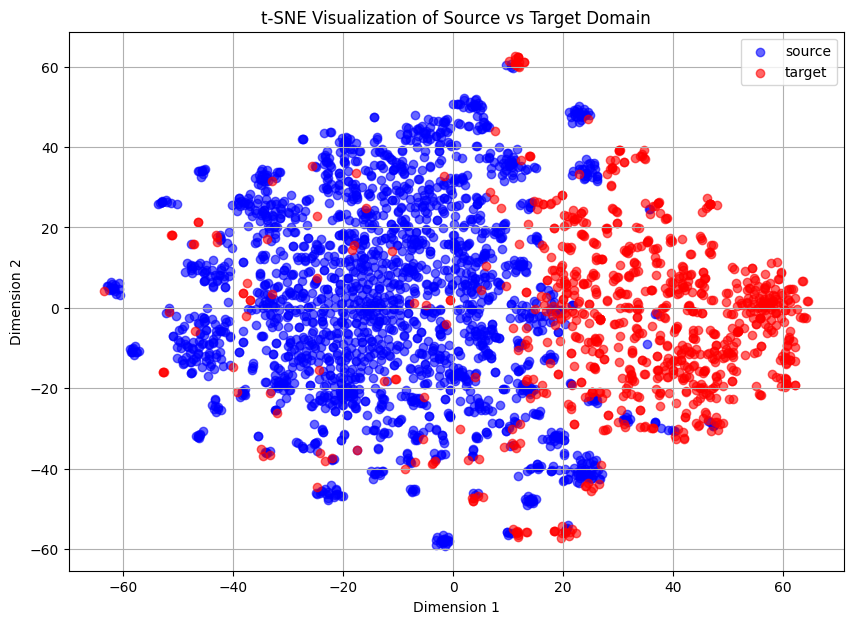

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Load your two datasets
df_source = pd.read_csv("/content/drive/MyDrive/Diabetes_cleaned.csv")
df_target = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1')

# Rename 'Text ' column (remove trailing space)
df_target.rename(columns=lambda x: x.strip(), inplace=True)  # Remove extra spaces in column names

# Tag domains
df_source['domain'] = 'source'
df_target['domain'] = 'target'

# Standardize to a 'content' column
df_source = df_source[['content', 'domain']]
df_target = df_target[['Text', 'domain']].rename(columns={'Text': 'content'})

# Combine and drop NaN values
df_all = pd.concat([df_source, df_target], ignore_index=True)
df_all.dropna(subset=['content'], inplace=True)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df_all['content']).toarray()

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Plotting
plt.figure(figsize=(10, 7))
colors = {'source': 'blue', 'target': 'red'}
for domain in ['source', 'target']:
    idx = df_all['domain'] == domain
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], c=colors[domain], label=domain, alpha=0.6)

plt.title("t-SNE Visualization of Source vs Target Domain")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

# === Dataset ===
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.encodings = self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.texts)

# === Load Data ===
df = pd.read_csv("/content/drive/MyDrive/Corrected_Labeled.csv", encoding='ISO-8859-1').dropna()
print("Label distribution:")
print(df['Label'].value_counts())

train_df, val_df = train_test_split(df, test_size=0.15, stratify=df['Label'], random_state=42)

train_texts = train_df['Text '].tolist()
train_labels = train_df['Label'].astype(int).tolist()
val_texts = val_df['Text '].tolist()
val_labels = val_df['Label'].astype(int).tolist()

train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# === Handle Class Imbalance ===
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:", class_weights)

sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=8)

# === Model ===
class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

# === Initialize Model + Load Adapted BioBERT Weights ===
model = FineTuneModel(num_classes=3).to(device)
adapted_weights = torch.load("/content/drive/MyDrive/biobert_dann_adapted.pt", map_location=device)
model.encoder.load_state_dict(adapted_weights, strict=False)

# === No Freezing — All layers trainable ===

# === Loss, Optimizer, Early Stopping ===
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

best_val_acc = 0
patience = 3
no_improve = 0

# === Evaluation ===
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attn_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, digits=4))
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    return acc

# === Training Loop ===
for epoch in range(15):  # more epochs allowed now
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attn_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"\nEpoch {epoch+1} | Training Loss: {avg_loss:.4f}")

    val_acc = evaluate(model, val_loader)
    print(f"→ Val Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/newbiobert_finetuned_3class_final.pt")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


Label distribution:
Label
0    575
1    167
2    160
Name: count, dtype: int64
Class Weights: [0.52322404 1.79812207 1.87745098]

Epoch 1 | Training Loss: 0.7947
              precision    recall  f1-score   support

           0     0.9130    0.2414    0.3818        87
           1     0.4651    0.8000    0.5882        25
           2     0.2571    0.7500    0.3830        24

    accuracy                         0.4338       136
   macro avg     0.5451    0.5971    0.4510       136
weighted avg     0.7150    0.4338    0.4200       136

→ Val Accuracy: 0.4338

Epoch 2 | Training Loss: 0.4165
              precision    recall  f1-score   support

           0     0.9062    0.6667    0.7682        87
           1     0.6774    0.8400    0.7500        25
           2     0.4390    0.7500    0.5538        24

    accuracy                         0.7132       136
   macro avg     0.6742    0.7522    0.6907       136
weighted avg     0.7817    0.7132    0.7270       136

→ Val Accuracy: 0.71

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 102.1 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer
from torch import nn
from transformers import AutoModel

# === Rebuild Model Class ===
class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

# === Load Model ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FineTuneModel(num_classes=3).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/newbiobert_finetuned_3class_final.pt", map_location=device))
model.eval()

# === Tokenizer & Dummy Input ===
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
dummy_input = tokenizer(
    "ONNX conversion test input",
    return_tensors="pt",
    padding="max_length",
    truncation=True,
    max_length=128  # set a fixed length for dummy input
)

# Move dummy input tensors to same device as model
input_ids = dummy_input["input_ids"].to(device)
attention_mask = dummy_input["attention_mask"].to(device)

# === Export to ONNX ===
torch.onnx.export(
    model,
    (input_ids, attention_mask),
    "/content/drive/MyDrive/newbiobert_finetuned_3class.onnx",
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "sequence_length"},
        "attention_mask": {0: "batch_size", 1: "sequence_length"},
        "logits": {0: "batch_size"}
    },
    opset_version=17  # Change from 11 to 17
)




In [ ]:
import torch
import torch.nn as nn
import os
from transformers import AutoTokenizer, AutoModel

# === Rebuild your trained model ===
class FineTuneModel(nn.Module):
    def __init__(self, num_classes=3, hidden_size=768):
        super(FineTuneModel, self).__init__()
        self.encoder = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state[:, 0, :]
        return self.classifier(pooled)

# === Load model ===
model = FineTuneModel(num_classes=3)
model.load_state_dict(torch.load("/content/drive/MyDrive/newbiobert_finetuned_3class_final.pt", map_location="cpu"))
model.eval()

# === Save to directory ===
save_dir = "/content/drive/MyDrive/newbiobert_model_3class"
os.makedirs(save_dir, exist_ok=True)

# Save PyTorch weights and tokenizer
torch.save(model.state_dict(), f"{save_dir}/pytorch_model.bin")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
tokenizer.save_pretrained(save_dir)

print(f"✅ Saved model + tokenizer to: {save_dir}")


✅ Saved model + tokenizer to: /content/drive/MyDrive/newbiobert_model_3class


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class BioBERTClassifier(nn.Module):
    def __init__(self, model_name="dmis-lab/biobert-base-cased-v1.1", num_labels=3):
        super(BioBERTClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(cls_output)



#Setup device and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

#Load both models
model_A = BioBERTClassifier().to(device)  # Model without Social_Eval
model_B = BioBERTClassifier().to(device)  # Model with Social_Eval

model_A.load_state_dict(torch.load("/content/drive/MyDrive/newbiobert_finetuned_3class_final.pt", map_location=device))
model_B.load_state_dict(torch.load("/content/drive/MyDrive/biobert_finetuned_3class_final.pt", map_location=device))

model_A.eval()
model_B.eval()

#Prediction function
def predict(model, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs)
        probs = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    return predicted_class, probs.cpu().numpy()

#Test claims
test_claims = [
    "Cinnamon can help reduce blood sugar levels.",
    "Eating ice cream prevents diabetes.",
    "Exercise helps manage diabetes.",
    "Avocados cure diabetes.",
    "High blood sugar can lead to nerve damage.",
    "Drinking green tea completely reverses diabetes.",
    "Skipping meals cures diabetes.",
    "Prediabetes always turns into diabetes.",
    "Only obese people get diabetes.",
    "Drinking water helps control blood sugar levels."
]

#Run predictions for both models
for claim in test_claims:
    pred_A, prob_A = predict(model_A, claim)
    pred_B, prob_B = predict(model_B, claim)

    print(f"Claim: {claim}")
    print(f"Model A (No Social Eval): Label={pred_A}, Prob={prob_A}")
    print(f"Model B (With Social Eval): Label={pred_B}, Prob={prob_B}")



🧪 Claim: Cinnamon can help reduce blood sugar levels.
🔹 Model A (No Social Eval): Label=2, Prob=[[0.01185277 0.00493683 0.98321044]]
🔸 Model B (With Social Eval): Label=0, Prob=[[0.9847074  0.0069375  0.00835511]]

🧪 Claim: Eating ice cream prevents diabetes.
🔹 Model A (No Social Eval): Label=1, Prob=[[0.02763681 0.9605287  0.01183452]]
🔸 Model B (With Social Eval): Label=1, Prob=[[0.01031001 0.9789601  0.0107299 ]]

🧪 Claim: Exercise helps manage diabetes.
🔹 Model A (No Social Eval): Label=0, Prob=[[0.5262639  0.01640907 0.45732707]]
🔸 Model B (With Social Eval): Label=0, Prob=[[0.9800251  0.00689628 0.01307869]]

🧪 Claim: Avocados cure diabetes.
🔹 Model A (No Social Eval): Label=1, Prob=[[0.01602555 0.97413    0.00984447]]
🔸 Model B (With Social Eval): Label=1, Prob=[[0.00564034 0.991189   0.00317067]]

🧪 Claim: High blood sugar can lead to nerve damage.
🔹 Model A (No Social Eval): Label=0, Prob=[[0.929161   0.03565569 0.03518329]]
🔸 Model B (With Social Eval): Label=0, Prob=[[0.984

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class BioBERTClassifier(nn.Module):
    def __init__(self, model_name="dmis-lab/biobert-base-cased-v1.1", num_labels=3):
        super(BioBERTClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(cls_output)



#Setup device and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

#Load both models
model_A = BioBERTClassifier().to(device)  # Model without Social_Eval
model_B = BioBERTClassifier().to(device)  # Model with Social_Eval

model_A.load_state_dict(torch.load("/content/drive/MyDrive/newbiobert_finetuned_3class_final.pt", map_location=device))
model_B.load_state_dict(torch.load("/content/drive/MyDrive/biobert_finetuned_3class_final.pt", map_location=device))

model_A.eval()
model_B.eval()

#Prediction function
def predict(model, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs)
        probs = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    return predicted_class, probs.cpu().numpy()

#Test claims
test_claims = [
    # Definitions
    "Insulin is a hormone that helps regulate blood sugar levels in the body.",
    "Type 1 diabetes is caused by insulin resistance.",

    #Medications
    "Metformin is the first-line medication for type 2 diabetes.",
    "You can stop taking metformin once your blood sugar is under control.",
    "Insulin therapy is only for people with type 1 diabetes.",

    #Herbs and supplements
    "Bitter melon can be used to help manage blood sugar levels.",
    "Fenugreek completely cures diabetes.",
    "Aloe vera has shown potential in lowering blood glucose in some studies.",
    "Ginseng is clinically proven to replace insulin.",

    #Misconceptions & nuanced
    "You don't need insulin if you eat healthy with type 1 diabetes.",
    "Diabetes is reversible with diet and exercise alone.",
    "Taking too much insulin can lead to hypoglycemia.",
    "People with diabetes should avoid all fruits.",
    "Type 2 diabetes only affects overweight people.",

    #Grounded facts
    "Hypoglycemia refers to dangerously low blood sugar levels.",
    "HbA1c reflects your average blood sugar levels over the past 3 months.",
    "Carbohydrates raise blood sugar levels faster than protein or fat.",
    "Diabetes can lead to complications such as kidney failure and vision loss.",
]


#Run predictions for both models
for claim in test_claims:
    pred_A, prob_A = predict(model_A, claim)
    pred_B, prob_B = predict(model_B, claim)

    print(f"\n🧪 Claim: {claim}")
    print(f"🔹 Model A (With Social Eval): Label={pred_A}, Prob={prob_A}")
    print(f"🔸 Model B (No Social Eval): Label={pred_B}, Prob={prob_B}")



🧪 Claim: Insulin is a hormone that helps regulate blood sugar levels in the body.
🔹 Model A (With Social Eval): Label=0, Prob=[[0.8456433  0.01488666 0.13946998]]
🔸 Model B (No Social Eval): Label=2, Prob=[[0.29678556 0.00757626 0.69563824]]

🧪 Claim: Type 1 diabetes is caused by insulin resistance.
🔹 Model A (With Social Eval): Label=0, Prob=[[0.92312455 0.05042282 0.02645263]]
🔸 Model B (No Social Eval): Label=1, Prob=[[0.05188045 0.9432108  0.0049088 ]]

🧪 Claim: Metformin is the first-line medication for type 2 diabetes.
🔹 Model A (With Social Eval): Label=0, Prob=[[0.9091039  0.06571032 0.02518587]]
🔸 Model B (No Social Eval): Label=0, Prob=[[0.9851509  0.00735623 0.00749281]]

🧪 Claim: You can stop taking metformin once your blood sugar is under control.
🔹 Model A (With Social Eval): Label=0, Prob=[[0.900841   0.07035439 0.0288046 ]]
🔸 Model B (No Social Eval): Label=1, Prob=[[0.4372446  0.55212045 0.01063498]]

🧪 Claim: Insulin therapy is only for people with type 1 diabetes.
🔹

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

class BioBERTClassifier(nn.Module):
    def __init__(self, model_name="dmis-lab/biobert-base-cased-v1.1", num_labels=3):
        super(BioBERTClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_labels)
        )

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(cls_output)



#Setup device and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

#Load both models
model_A = BioBERTClassifier().to(device)  # Model without Social_Eval
model_B = BioBERTClassifier().to(device)  # Model with Social_Eval

model_A.load_state_dict(torch.load("/content/drive/MyDrive/newbiobert_finetuned_3class_final.pt", map_location=device))
model_B.load_state_dict(torch.load("/content/drive/MyDrive/biobert_finetuned_3class_final.pt", map_location=device))

model_A.eval()
model_B.eval()

# Prediction function
def predict(model, text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs)
        probs = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probs, dim=1).item()

    return predicted_class, probs.cpu().numpy()
test_claims = [
    "bruh my aunt used cinnamon for weeks nd her sugar went down lol maybe its working??",
    "yo anyone tried dat aloe vera ting for sugar probs? feelin kinda better but idk",
    "tbh i stopped taking insulin nd im eating clean, blood sugar kinda stable fr",
    "they said diabetes gone if u exercise & eat ok for some months?? is that tru fr?",
    "just drink bitter leaf juice u no need metformin again 😭",
    "lol my uncle eats ice cream everyday nd no diabetes soooo???",
    "nah man, fruits r bad for diabetics. they got sugar!",
    "green tea be magic for diabetes trust me 😤",
    "my mom use turmeric now she no take pills again",
    "doc said high sugar can mess with ur eyes and nerves? damn 😟",
    "pre-diabetes = full blown diabetes eventually innit?",
    "yall stop carbs completely, dats how u cure sugar disease fr fr",
    "sugar meds are a scam, just fast and walk everyday 😒",
    "hbA1c? lol idk but doc said mine is 9 n its bad lmaooo",
]

# Run predictions for both models
for claim in test_claims:
    pred_A, prob_A = predict(model_A, claim)
    pred_B, prob_B = predict(model_B, claim)

    print(f"Claim: {claim}")
    print(f" Model A (With Social Eval): Label={pred_A}, Prob={prob_A}")
    print(f"Model B (No Social Eval): Label={pred_B}, Prob={prob_B}")



🧪 Claim: bruh my aunt used cinnamon for weeks nd her sugar went down lol maybe its working??
🔹 Model A (With Social Eval): Label=2, Prob=[[0.04029209 0.18232648 0.7773814 ]]
🔸 Model B (No Social Eval): Label=2, Prob=[[0.02866841 0.01055789 0.96077365]]

🧪 Claim: yo anyone tried dat aloe vera ting for sugar probs? feelin kinda better but idk
🔹 Model A (With Social Eval): Label=1, Prob=[[0.07375152 0.534545   0.3917035 ]]
🔸 Model B (No Social Eval): Label=2, Prob=[[0.3647854  0.11791422 0.51730037]]

🧪 Claim: tbh i stopped taking insulin nd im eating clean, blood sugar kinda stable fr
🔹 Model A (With Social Eval): Label=1, Prob=[[0.05597821 0.8895057  0.05451609]]
🔸 Model B (No Social Eval): Label=1, Prob=[[0.23004851 0.7006547  0.06929681]]

🧪 Claim: they said diabetes gone if u exercise & eat ok for some months?? is that tru fr?
🔹 Model A (With Social Eval): Label=2, Prob=[[0.02572851 0.0196967  0.9545747 ]]
🔸 Model B (No Social Eval): Label=0, Prob=[[0.87640154 0.02733461 0.09626388]